In [ ]:
!pip install git+https://github.com/keras-team/keras-tuner.git -q
!pip install autokeras -q
!pip install lightgbm==3.2.0 -q

     |████████████████████████████████| 174kB 6.0MB/s 
     |████████████████████████████████| 2.0MB 4.4MB/s 


### Load dataset

In [ ]:
from sklearn.datasets import fetch_california_housing

house_dataset = fetch_california_housing()

# Import pandas package to format the data
import pandas as pd

# Extract features with their names into the a dataframe format
data = pd.DataFrame(house_dataset.data, columns=house_dataset.feature_names)

# Extract target with their names into a pd.Series object with name MEDV
target = pd.Series(house_dataset.target, name = 'MEDV')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

### Use LightGBM GBDT model to do regression without tuning

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

gbdt_model = lgb.LGBMRegressor(
                    boosting_type='gbdt',
                    num_leaves=31,
                    learning_rate=0.05,
                    n_estimators=10
                    )  # create model

validation_data = (X_val, y_val)
gbdt_model.fit(X_train, y_train,
        eval_set=[validation_data],
        eval_metric='mse',
        early_stopping_rounds=5) # fit the model

# evalaute model
y_pred_gbdt = gbdt_model.predict(X_test, num_iteration=gbdt_model.best_iteration_)
test_mse_1 = mean_squared_error(y_test, y_pred_gbdt)
print("The GBDT prediction MSE on test set: {}".format(test_mse_1))

[1]	valid_0's l2: 1.28051
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 1.2009
[3]	valid_0's l2: 1.1316
[4]	valid_0's l2: 1.06506
[5]	valid_0's l2: 1.00734
[6]	valid_0's l2: 0.952642
[7]	valid_0's l2: 0.903993
[8]	valid_0's l2: 0.857114
[9]	valid_0's l2: 0.815805
[10]	valid_0's l2: 0.778275
Did not meet early stopping. Best iteration is:
[10]	valid_0's l2: 0.778275
The GBDT prediction MSE on test set: 0.7514642734431766


### Create the LightGBM model building function (search space)

In [ ]:
def build_model(hp):
    model = lgb.LGBMRegressor(
                        boosting_type='gbdt',
                        # you can also search model type such as: 
                        # boosting_type=hp.Choice("model_type", ['gbdt', 'goss'], default='gbdt'),
                        num_leaves=hp.Int("num_leaves", 5, 50, step=1),
                        learning_rate=hp.Float('learning_rate', 1e-3, 1, sampling='log', default=0.01),
                        n_estimators=hp.Int('n_estimators', 5, 50, step=1)
                        )

    return model

### Customize tuner

In [ ]:
import os
import pickle
import tensorflow as tf
import kerastuner as kt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

class LightGBMTuner(kt.engine.base_tuner.BaseTuner):

    def run_trial(self, trial, X, y, validation_data):
        model = self.hypermodel.build(trial.hyperparameters) # build the model
        model.fit(X_train, y_train,
                eval_set=[validation_data],
                eval_metric='mse',
                early_stopping_rounds=5) # fit the model
        X_val, y_val = validation_data
        y_pred = model.predict(X_val, num_iteration=model.best_iteration_) # evaluate the model
        eval_mse = mean_squared_error(y_val, y_pred)
        self.oracle.update_trial(trial.trial_id, {'mse': eval_mse})  # inform the oracle of the eval result, the result is a dictionary with the metric names as the keys.
        self.save_model(trial.trial_id, model) # save the model to disk

    def save_model(self, trial_id, model, step=0):
        fname = os.path.join(self.get_trial_dir(trial_id), 'model.txt')
        model.booster_.save_model(fname, num_iteration=model.best_iteration_) 

    def load_model(self, trial):
        fname = os.path.join(self.get_trial_dir(trial.trial_id), 'model.txt')
        model = lgb.Booster(model_file=fname)
        return model

### Use build-in random search algorithm to tune models

In [ ]:
my_lightgbm_tuner = LightGBMTuner(
        oracle=kt.oracles.RandomSearch(
            objective=kt.Objective('mse', 'min'),
            max_trials=100,
            seed=42),
        hypermodel=build_model,
        overwrite=True,
        project_name='my_lightgbm_tuner')

my_lightgbm_tuner.search(X_train, y_train, validation_data=(X_val, y_val))

Trial 100 Complete [00h 00m 00s]
mse: 0.8565818768549603

Best mse So Far: 0.23615237093831826
Total elapsed time: 00h 00m 15s
INFO:tensorflow:Oracle triggered exit


### Evaluate the best discovered model

In [ ]:
from sklearn.metrics import mean_squared_error

best_model = my_lightgbm_tuner.get_best_models(1)[0]
y_pred_test = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
print("The prediction MSE on test set: {}".format(test_mse))

The prediction MSE on test set: 0.22039670222190072


### Customize random search algorithm

In [ ]:
from kerastuner.engine.oracle import Oracle
from kerastuner.engine import trial as trial_lib
import numpy as np
import tensorflow as tf
import autokeras as ak

SEED = 42
np.random.seed=SEED
tf.random.set_seed(SEED)

class RandomSearchOracle(Oracle):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Add any new attributes.

    def _populate_space(self, trial_id):
        """Fill the hyperparameter space with values for a trial.
        This method should be overridden in subclasses and called in
        `create_trial` in order to populate the hyperparameter space with
        values.
        Args:
          `trial_id`: The id for this Trial.
        Returns:
            A dictionary with keys "values" and "status", where "values" is
            a mapping of parameter names to suggested values, and "status"
            is the TrialStatus that should be returned for this trial (one
            of "RUNNING", "IDLE", or "STOPPED").
        """
        values = self._random_values()
        if values is None:
            return {'status': trial_lib.TrialStatus.STOPPED,
                    'values': None}
        return {'status': trial_lib.TrialStatus.RUNNING,
                'values': values}

    def update_trial(self, trial_id, metrics, step=0):
        """Used by a worker to report the status of a trial.
        Args:
            trial_id: A previously seen trial id.
            metrics: Dict of float. The current value of this
                trial's metrics.
            step: (Optional) Float. Used to report intermediate results. The
                current value in a timeseries representing the state of the
                trial. This is the value that `metrics` will be associated with.
        Returns:
            Trial object. Trial.status will be set to "STOPPED" if the Trial
            should be stopped early.
        """
        super().update_trial(trial_id, metrics, step)

### Use customized random search algorithm to tune models

In [ ]:
my_lightgbm_tuner = LightGBMTuner(
        oracle=RandomSearchOracle(
            objective=kt.Objective('mse', 'min'),
            max_trials=100,
            seed=42),
        hypermodel=build_model,
        overwrite=True,
        project_name='my_lightgbm_tuner')

my_lightgbm_tuner.search(X_train, y_train, validation_data=(X_val, y_val))


Trial 100 Complete [00h 00m 00s]
mse: 0.8565818768549603

Best mse So Far: 0.23615237093831826
Total elapsed time: 00h 00m 16s
INFO:tensorflow:Oracle triggered exit


In [ ]:
from sklearn.metrics import mean_squared_error

best_model = my_lightgbm_tuner.get_best_models(1)[0]
y_pred_test = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
print("The prediction MSE on test set: {}".format(test_mse))

The prediction MSE on test set: 0.22039670222190072


### Plot search curves

In [ ]:
import matplotlib.pyplot as plt 

def plot_curve(x, y, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel) 
    plt.title(title)
    plt.show()


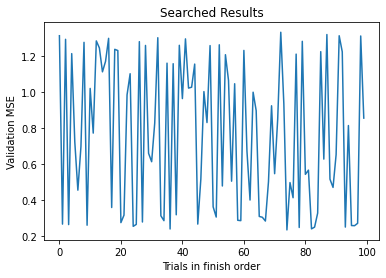

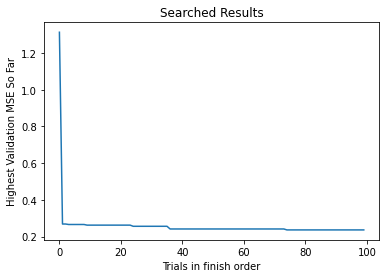

In [ ]:
mse = [my_lightgbm_tuner.oracle.get_trial(trial_id).score for trial_id in my_lightgbm_tuner.oracle.end_order]
ids = list(range(len(mse)))
plot_curve(ids, mse, 'Trials in finish order', 'Validation MSE', 'Searched Results')

high_value = float('inf')
high_mse = []
for value in mse:
  high_value = min(high_value, value)
  high_mse.append(high_value)
plot_curve(ids, high_mse, 'Trials in finish order', 'Highest Validation MSE So Far', 'Searched Results')